### Setup and Dependency Installation

#### 📦 Import Library Umum
Import library dasar yang digunakan untuk manipulasi data, visualisasi, logging, dan utilitas lainnya.


In [1]:
import os
import re
import time
import json
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from dotenv import load_dotenv
from IPython.display import display, Markdown, HTML
from wordcloud import WordCloud

#### 🤖 Import TensorFlow dan Keras
Library ini digunakan untuk membangun dan melatih model deep learning seperti LSTM dan CNN.


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten

#### 📚 Import NLTK untuk NLP
Library Natural Language Toolkit (NLTK) digunakan untuk tokenisasi dan menghapus stopwords dari teks.


In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#### 🧠 Import Scikit-learn
Digunakan untuk preprocessing teks, evaluasi model, dan teknik reduksi dimensi seperti PCA/SVD.


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD

#### 🤗 Import Transformers dari HuggingFace
Model transformer seperti BERT, RoBERTa, dan XLNet digunakan untuk analisis sentimen berbasis deep learning modern.

In [5]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline,
    BertTokenizer,
    BertForSequenceClassification,
    RobertaTokenizer,
    RobertaForSequenceClassification,
    XLNetTokenizer,
    XLNetForSequenceClassification,
)
from huggingface_hub import InferenceClient

#### 🌐 Import Google API
Untuk mengambil data dari YouTube dan mengakses model generatif Google (Gemini).

In [6]:
from googleapiclient.discovery import build
import google.generativeai as genai

#### ⚙️ Nonaktifkan Warning & Atur Tampilan
Untuk menghindari cluttering pada output dan mempercantik visualisasi.


In [7]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

pd.set_option("display.max_colwidth", 100)
plt.style.use("seaborn-v0_8-whitegrid")
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

🔕 Baris ini menonaktifkan pesan log non-kritis dari `matplotlib` agar tidak mengganggu tampilan output saat plotting.

In [67]:
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

#### 📥 Download Resource NLTK
Mengunduh resource NLTK yang dibutuhkan untuk tokenisasi dan stopword bahasa Indonesia.


In [8]:
print("Downloading NLTK resources...")
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
stop_words = set(stopwords.words("indonesian"))

print("✅ All required libraries imported successfully")
print("✅ NLTK resources downloaded successfully")

✅ All required libraries imported successfully
✅ NLTK resources downloaded successfully


### Environment Setup and Configuration

#### 📋 Logging Initialization
Mengatur sistem logging untuk mencatat aktivitas selama eksekusi pipeline, termasuk format waktu dan level informasi.


In [ ]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

#### 🔐 Setup Gemini API (Google Generative AI)
Mengambil API Key Gemini dari environment variable atau meminta input jika tidak tersedia. Kemudian inisialisasi model `gemini-2.0-flash`.

In [ ]:
GEMINI_API_KEYS = [
    v for k, v in os.environ.items()
    if k.startswith("GEMINI_API_KEY_") and v
]
if not GEMINI_API_KEYS:
    GEMINI_API_KEYS = [
        input(f"Enter Gemini API Key #{i+1}: ")
        for i in range(5)
    ]

# Konfigurasi model Gemini
models = [genai.GenerativeModel('gemini-2.0-flash') for _ in GEMINI_API_KEYS]
for api_key, model in zip(GEMINI_API_KEYS, models):
    genai.configure(api_key=api_key)

#### 📺 Setup YouTube API
Mengambil API Key YouTube dan ID video dari environment variable atau input user.


In [ ]:
YOUTUBE_API_KEY = os.getenv('YOUTUBE_API_KEY') or input("Enter your YouTube API Key: ")
VIDEO_ID        = os.getenv('VIDEO_ID')        or input("Enter the YouTube Video ID: ")

#### 🤗 Setup Hugging Face API
Mengambil API Key Hugging Face dari environment variable atau input manual, lalu inisialisasi client.

In [ ]:
HF_API_KEYS = [
    v for k, v in os.environ.items()
    if k.startswith("HF_API_KEY_") and v
]
if not HF_API_KEYS:
    HF_API_KEYS = [
        input(f"Enter Hugging Face API Key #{i+1}: ")
        for i in range(3)
    ]

hf_clients = [InferenceClient(token=api_key) for api_key in HF_API_KEYS]

#### 🗂️ Setup Struktur Direktori Output
Membuat struktur folder untuk menyimpan hasil setiap tahap analisis seperti pengumpulan data, preprocessing, analisis, dll.


In [ ]:
BASE_OUTPUT = os.getenv('OUTPUT_DIR', './output')

STAGES = {
    '01_comments_collection':     None,
    '02_preprocessing':           None,
    '03_eda':                     None,
    '04_clustering':              None,
    '05_sentiment':               None,
    '06_transformer_comparison':  None,
    '07_advanced_insights':       None
}

subdirs = {}
for stage in STAGES:
    stage_path = os.path.join(BASE_OUTPUT, stage)
    os.makedirs(stage_path, exist_ok=True)
    subdirs[stage] = {}
    for sub in ('analisis', 'visualisasi'):
        path = os.path.join(stage_path, sub)
        os.makedirs(path, exist_ok=True)
        subdirs[stage][sub] = path

#### ✅ Logging Struktur Folder Output
Menampilkan struktur folder yang telah dibuat ke dalam log agar mudah dilacak dan dipastikan.

In [ ]:
logger.info("Directory structure initialized under %s", BASE_OUTPUT)
for stage, subs in subdirs.items():
    logger.info("Stage %-25s:", stage)
    for name, path in subs.items():
        logger.info("  - %-12s -> %s", name, path)

2025-05-09 04:52:10 INFO Directory structure initialized under ./output
2025-05-09 04:52:10 INFO Stage 01_comments_collection   :
2025-05-09 04:52:10 INFO   - analisis     -> ./output/01_comments_collection/analisis
2025-05-09 04:52:10 INFO   - visualisasi  -> ./output/01_comments_collection/visualisasi
2025-05-09 04:52:10 INFO Stage 02_preprocessing         :
2025-05-09 04:52:10 INFO   - analisis     -> ./output/02_preprocessing/analisis
2025-05-09 04:52:10 INFO   - visualisasi  -> ./output/02_preprocessing/visualisasi
2025-05-09 04:52:10 INFO Stage 03_eda                   :
2025-05-09 04:52:10 INFO   - analisis     -> ./output/03_eda/analisis
2025-05-09 04:52:10 INFO   - visualisasi  -> ./output/03_eda/visualisasi
2025-05-09 04:52:10 INFO Stage 04_clustering            :
2025-05-09 04:52:10 INFO   - analisis     -> ./output/04_clustering/analisis
2025-05-09 04:52:10 INFO   - visualisasi  -> ./output/04_clustering/visualisasi
2025-05-09 04:52:10 INFO Stage 05_sentiment             :


### YouTube Comments Collection

#### 📁 Inisialisasi Path Direktori
Menentukan lokasi folder untuk menyimpan data komentar mentah dan hasil visualisasi awal pada tahap `01_comments_collection`.


In [ ]:
COMMENTS_DIR = subdirs['01_comments_collection']['analisis']
VISUALS_DIR  = subdirs['01_comments_collection']['visualisasi']

#### 📥 Fungsi Pengambilan Komentar YouTube
Fungsi `get_youtube_comments` akan mengambil komentar dari sebuah video YouTube menggunakan YouTube Data API.
Komentar yang diambil mencakup nama pengguna, isi komentar, waktu publikasi, dan jumlah like.


In [ ]:
def get_youtube_comments(video_id: str, api_key: str) -> pd.DataFrame:
    client = build("youtube", "v3", developerKey=api_key)
    comments = []
    request = client.commentThreads().list(
        part="snippet",
        videoId=video_id,
        maxResults=100,
        textFormat="plainText"
    )
    with tqdm(desc="Fetching comments", unit="comment") as pbar:
        while request:
            response = request.execute()
            for item in response.get("items", []):
                s = item["snippet"]["topLevelComment"]["snippet"]
                comments.append({
                    "comment_id":   item["id"],
                    "author":       s.get("authorDisplayName"),
                    "text":         s.get("textDisplay"),
                    "published_at": s.get("publishedAt"),
                    "like_count":   s.get("likeCount", 0)
                })
                pbar.update(1)
            request = client.commentThreads().list_next(request, response)

    df = pd.DataFrame(comments)
    logger.info("Retrieved %d comments", len(df))
    return df

#### ▶️ Eksekusi Pengambilan Komentar
Menjalankan fungsi `get_youtube_comments` untuk mengambil komentar dari video sesuai ID yang telah ditentukan.


In [17]:
logger.info("Starting YouTube comment collection for video %s", VIDEO_ID)
df_comments = get_youtube_comments(VIDEO_ID, YOUTUBE_API_KEY)

2025-05-09 04:52:10 INFO Starting YouTube comment collection for video -WLpXmnBmxo
2025-05-09 04:52:10 INFO file_cache is only supported with oauth2client<4.0.0
Fetching comments: 10408comment [00:14, 708.80comment/s]
2025-05-09 04:52:25 INFO Retrieved 10408 comments


#### 💾 Menyimpan Komentar ke CSV
Komentar yang telah dikumpulkan disimpan dalam file CSV agar bisa digunakan untuk tahap selanjutnya seperti preprocessing dan analisis.


In [18]:
csv_path = os.path.join(COMMENTS_DIR, "comments_raw.csv")
df_comments.to_csv(csv_path, index=False)
logger.info("Saved raw comments to %s", csv_path)

2025-05-09 04:52:25 INFO Saved raw comments to ./output/01_comments_collection/analisis/comments_raw.csv


#### 🖼️ Menampilkan Sampel Komentar
Melihat beberapa komentar pertama yang berhasil dikumpulkan sebagai verifikasi awal terhadap data yang diambil.


In [19]:
display(Markdown("#### Sample of Collected Comments"))
display(df_comments.head())

#### Sample of Collected Comments

,comment_id,author,text,published_at,like_count
0,UgzE0LnnlcVrnEXWSbJ4AaABAg,@juranggandul,😊,2025-05-08T20:32:08Z,0
1,UgxIeaw8hDzoe9hahqZ4AaABAg,@MakmunMaulana-j8v,Kuci likan ka loka lu ciri lu Bangi Gung jawab tu,2025-05-08T11:42:35Z,0
2,UgyWQqzajDMtwO04KHB4AaABAg,@MakmunMaulana-j8v,Bangi kang tin satu akan bingan seakan jasnni Nina tu kan kan Bangi nah rus tuk sa Ra inonesa ki...,2025-05-08T11:40:11Z,0
3,UgzFqGTBxeMvb3ZeKax4AaABAg,@Kalandra-qk3bl,kok film jumbo gw begini,2025-05-08T08:01:34Z,0
4,UgwBpiBAPmLFVkSXdDl4AaABAg,@tonisuhartono4766,🇮🇩\n💙💝✌🏻\n👍👍👍👍👍👍👍👍👍👍👍👍👍👍,2025-05-08T01:19:06Z,0


### Data Preprocessing and Cleaning

#### 📁 Inisialisasi Direktori Preprocessing
Menentukan direktori untuk menyimpan hasil preprocessing dan visualisasi tahap kedua (`02_preprocessing`).


In [ ]:
PREPROCESS_DIR = subdirs['02_preprocessing']['analisis']
VISUAL_DIR     = subdirs['02_preprocessing']['visualisasi']
os.makedirs(PREPROCESS_DIR, exist_ok=True)
os.makedirs(VISUAL_DIR, exist_ok=True)

#### 🧬 Duplikasi Data & Cek Missing Values
Menduplikasi dataframe asli untuk preprocessing dan menampilkan jumlah nilai kosong (missing values) pada setiap kolom.

In [ ]:
df = df_comments.copy()

missing = df.isnull().sum()
percent = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'missing_values': missing, 'percentage': percent})
display(missing_df)

,missing_values,percentage
comment_id,0,0.0
author,0,0.0
text,0,0.0
published_at,0,0.0
like_count,0,0.0


#### 🧹 Hapus Komentar Kosong & Siapkan Stopwords
Menghapus komentar yang tidak memiliki teks dan memuat daftar stopwords Bahasa Indonesia dari NLTK.

In [ ]:
df = df.dropna(subset=['text'])
stop_words = set(stopwords.words('indonesian'))

#### 🔧 Fungsi `clean_text`
Fungsi ini mengubah teks ke huruf kecil, menghapus tag HTML, link, tanda baca, angka, dan kata-kata tidak penting (stopwords).


In [ ]:
def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'<.*?>|http\S+|www\.\S+|https\S+|[^\w\s]|\d+', ' ', text)
    tokens = word_tokenize(text)
    return ' '.join(w for w in tokens if w not in stop_words and len(w) > 2)

#### 🧼 Terapkan `clean_text` ke Semua Komentar
Menerapkan fungsi pembersihan ke setiap komentar dan menghapus hasil yang kosong setelah dibersihkan.


In [24]:
df['cleaned_text'] = df['text'].apply(clean_text)
df = df[df['cleaned_text'].str.strip() != '']

#### 📊 Statistik Komentar
Menambahkan kolom panjang komentar sebelum dan sesudah dibersihkan, serta menghitung jumlah kata.
Ditampilkan statistik deskriptif dari hasil ini.


In [25]:
df['original_length'] = df['text'].str.len()
df['cleaned_length']  = df['cleaned_text'].str.len()
df['word_count']      = df['cleaned_text'].str.split().str.len()

stats = df[['original_length', 'cleaned_length', 'word_count']].describe()
display(stats)

,original_length,cleaned_length,word_count
count,10150.000000,10150.000000,10150.000000
mean,117.313202,70.874384,10.015961
std,178.690011,103.498132,13.663688
min,3.000000,3.000000,1.000000
25%,34.000000,21.000000,3.000000
50%,67.000000,41.000000,6.000000
75%,134.000000,82.000000,12.000000
max,5856.000000,2751.000000,339.000000


#### 💾 Simpan Hasil Preprocessing
Data komentar yang telah dibersihkan disimpan ke file CSV agar bisa digunakan di tahap berikutnya.


In [26]:
preprocessed_path = os.path.join(PREPROCESS_DIR, 'preprocessed_comments.csv')
df.to_csv(preprocessed_path, index=False)

#### 👀 Sampel Komentar Setelah Preprocessing
Menampilkan beberapa contoh komentar sebelum dan sesudah dibersihkan, beserta jumlah kata hasil pembersihan.

In [ ]:
display(df[['text', 'cleaned_text', 'word_count']].head())

,text,cleaned_text,word_count
1,Kuci likan ka loka lu ciri lu Bangi Gung jawab tu,kuci likan loka ciri bangi gung,6
2,Bangi kang tin satu akan bingan seakan jasnni Nina tu kan kan Bangi nah rus tuk sa Ra inonesa ki...,bangi kang tin bingan seakan jasnni nina bangi rus tuk inonesa kokan,12
3,kok film jumbo gw begini,film jumbo,2
5,Ngelihat komen masih banyak yg sadar ternyata,ngelihat komen sadar,3
6,"Krain maung, Ternyata meow..\nJawaban ga ada yg di jwb",krain maung meow jwb,4


### Exploratory Data Analysis (EDA)

#### 📁 Inisialisasi Direktori EDA dan Load Data
Membuat direktori untuk hasil analisis dan visualisasi EDA, lalu memuat data komentar yang sudah dipreproses.

In [28]:
EDA_ANALYSIS_DIR = subdirs['03_eda']['analisis']
EDA_VISUAL_DIR   = subdirs['03_eda']['visualisasi']
os.makedirs(EDA_ANALYSIS_DIR, exist_ok=True)
os.makedirs(EDA_VISUAL_DIR, exist_ok=True)

PREPROCESS_DIR   = subdirs['02_preprocessing']['analisis']
preprocessed_path = os.path.join(PREPROCESS_DIR, 'preprocessed_comments.csv')
df = pd.read_csv(preprocessed_path, parse_dates=['published_at'])

#### 🧪 Rekayasa Fitur Tambahan
Menambahkan fitur seperti jumlah kata, panjang teks, dan waktu publikasi (tanggal dan jam).

In [ ]:
df['word_count']       = df['cleaned_text'].str.split().str.len()
df['cleaned_length']   = df['cleaned_text'].str.len()
df['original_length']  = df['text'].str.len()
df['publication_date'] = df['published_at'].dt.normalize()
df['publication_hour'] = df['published_at'].dt.hour

#### 📏 Distribusi Panjang Komentar
Visualisasi distribusi dan boxplot untuk jumlah kata dan karakter dalam komentar.

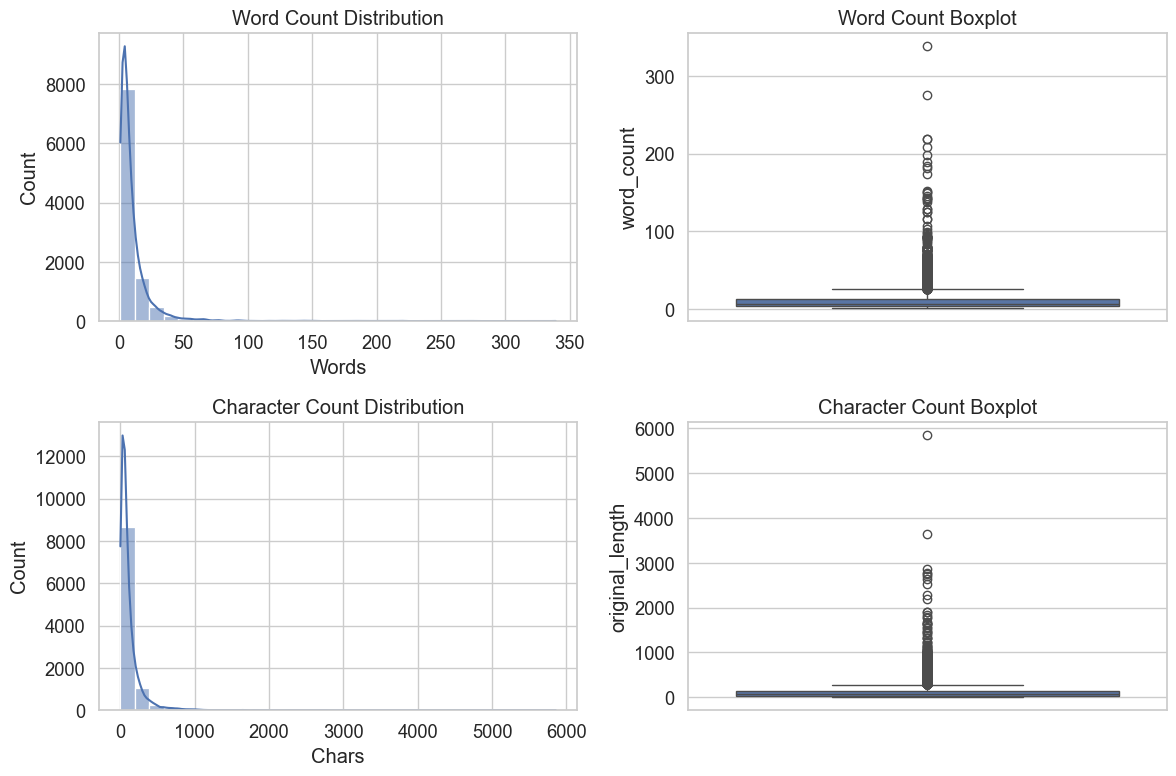

In [30]:
fig1, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df['word_count'], kde=True, bins=30, ax=axes[0,0]).set(title='Word Count Distribution', xlabel='Words')
sns.boxplot(y=df['word_count'], ax=axes[0,1]).set(title='Word Count Boxplot')
sns.histplot(df['original_length'], kde=True, bins=30, ax=axes[1,0]).set(title='Character Count Distribution', xlabel='Chars')
sns.boxplot(y=df['original_length'], ax=axes[1,1]).set(title='Character Count Boxplot')
fig1.tight_layout()
fig1.savefig(os.path.join(EDA_VISUAL_DIR, 'length_distribution.png'))
plt.show()

#### 🚨 Deteksi Outlier Jumlah Kata
Menghitung dan menyimpan komentar yang berada di luar rentang normal berdasarkan distribusi jumlah kata.

In [31]:
Q1, Q3 = df['word_count'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lb, ub = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
outliers = df[(df['word_count'] < lb) | (df['word_count'] > ub)]
outliers.to_csv(os.path.join(EDA_ANALYSIS_DIR, 'word_count_outliers.csv'), index=False)
display(outliers[['text', 'word_count']].sort_values('word_count', ascending=False).head())

,text,word_count
7986,"Saya nonton full 3 jam dan saya salut dengan Pak Presiden yang mau membuat acara seperti ini, ma...",339
7054,Ini adalah ringkasan yang dibuat oleh AI. Mungkin ada ketidakakuratan.\n\nDurasi 00:00:00 - 01:0...,276
8858,Analisis Kritis terhadap Gagasan Politik-Ekonomi Presiden Prabowo dalam wawancara ini: \n\n1. Pr...,219
7010,"Rekomendasi nonton minimal 1,5x\r\n\r\n28:40 P1 Alfito Deannova (DetikCom)\r\n\r\n29:17 Mulai Ja...",219
8959,"pertanyaan 150 hari pencapaian:\nawal-awal tidak dicatat.\n\n9:07: ""saya laksanakan keyakinan sa...",208


#### 🕒 Pola Waktu Publikasi Komentar
Visualisasi jumlah komentar berdasarkan tanggal dan jam publikasi.


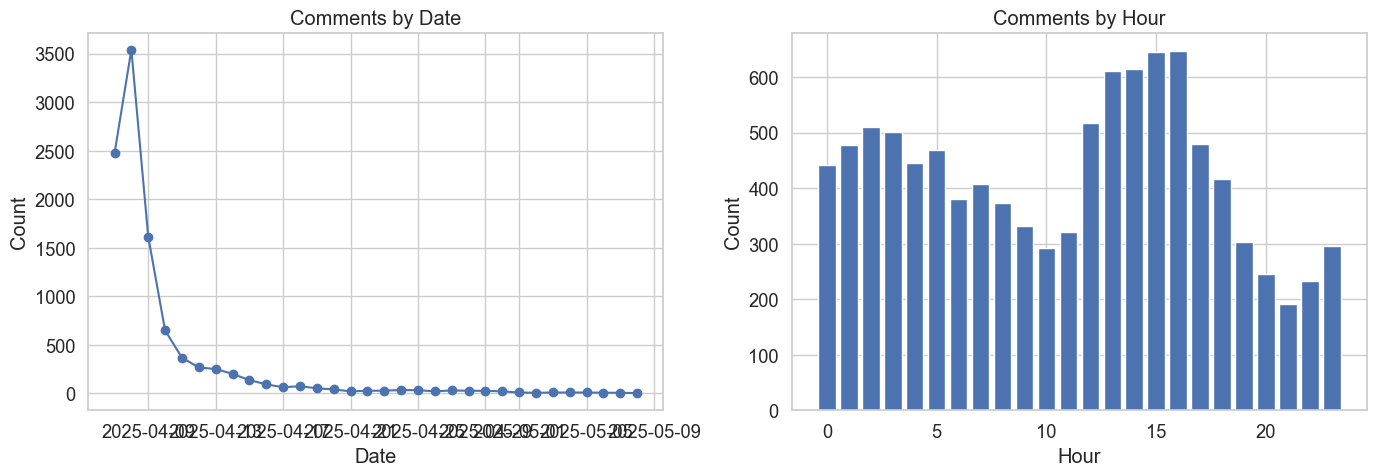

In [32]:
date_counts = df.groupby('publication_date').size()
hour_counts = df['publication_hour'].value_counts().sort_index()

fig2, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(date_counts.index, date_counts.values, marker='o')
axes[0].set(title='Comments by Date', xlabel='Date', ylabel='Count')
axes[1].bar(hour_counts.index, hour_counts.values)
axes[1].set(title='Comments by Hour', xlabel='Hour', ylabel='Count')
fig2.tight_layout()
fig2.savefig(os.path.join(EDA_VISUAL_DIR, 'publication_time.png'))
plt.show()

#### 👍 Distribusi Jumlah Like
Visualisasi distribusi dan boxplot untuk jumlah like pada komentar.

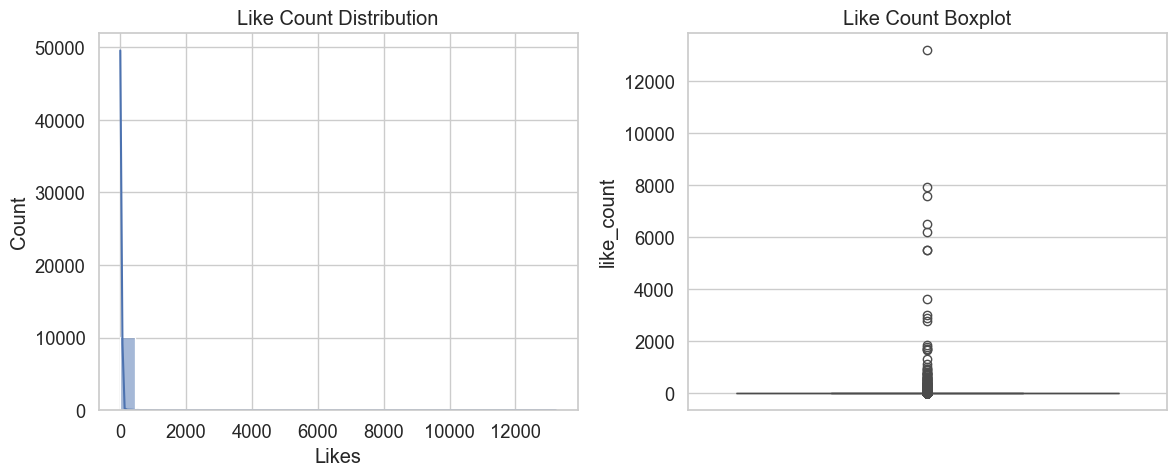

In [33]:
fig3, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['like_count'], kde=True, bins=30, ax=axes[0]).set(title='Like Count Distribution', xlabel='Likes')
sns.boxplot(y=df['like_count'], ax=axes[1]).set(title='Like Count Boxplot')
fig3.tight_layout()
fig3.savefig(os.path.join(EDA_VISUAL_DIR, 'like_count_analysis.png'))
plt.show()

#### 🌟 Top Komentar dengan Like Tertinggi
Menampilkan 5 komentar yang mendapat like terbanyak.

In [34]:
top_liked = df.nlargest(5, 'like_count')
display(top_liked[['author', 'text', 'like_count']])

,author,text,like_count
4931,@033_MUHAMMADARBYRAMADHAN,"Terima kasih, pak. Hasil diskusi ini berhasil menjawab kekhawatiran saya bahwa kita harus lebih ...",13223
7744,@dhimasputratama631,"Video ini sangat solutif, bagi saya yang memiliki gangguan pola tidur. Saya tadi malam susah tid...",7920
9147,@sofyanudin,1) *GANTI MENTERI2 KORUP*\n2) *SAHKAN UU PERAMPASAN ASSET KORUPTOR*\n3) *BATALKAN UU PERAMPASAN ...,7597
6947,@Xui_Ana,"Alhamdulillah video yg sangat bermanfaat, setiap beberapa detik saya mendengarkan saya selalu is...",6515
6408,@avichabastiansr5623,"Next, wakil presiden Gibran Rakabuming menjawab. Pliss harus sering ada acara² kayak giniii, bia...",6208


#### 🔠 Frekuensi Kata Terbanyak
Menampilkan 20 kata yang paling sering muncul dalam komentar yang sudah dibersihkan.


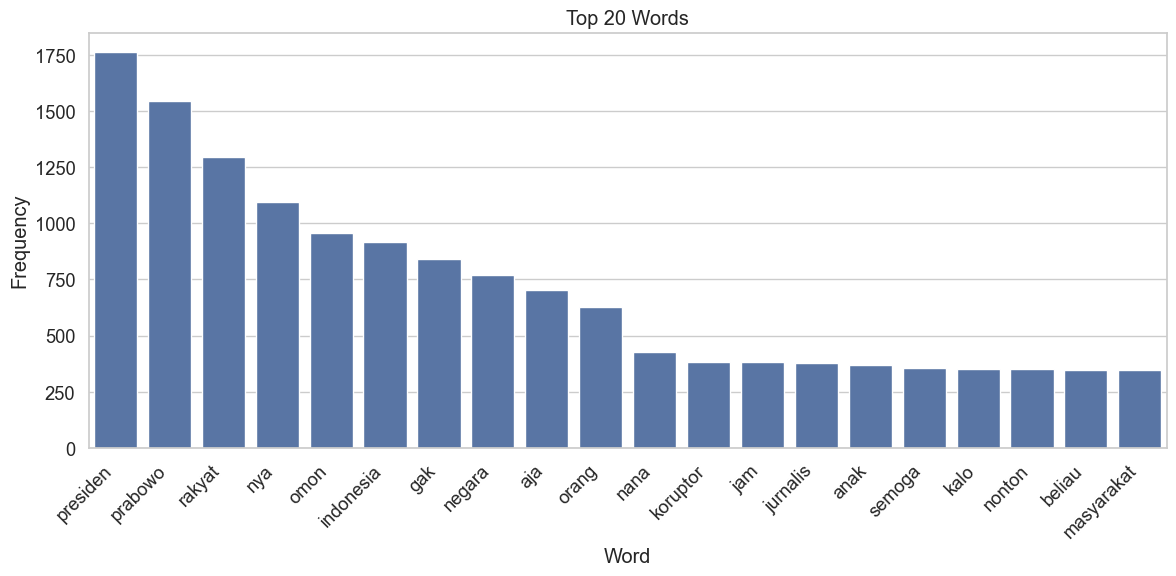

In [35]:
words, counts = zip(*Counter(" ".join(df['cleaned_text']).split()).most_common(20))
fig4 = plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts), ax=fig4.add_subplot(111)).set(title='Top 20 Words', xlabel='Word', ylabel='Frequency')
plt.xticks(rotation=45, ha='right')
fig4.tight_layout()
fig4.savefig(os.path.join(EDA_VISUAL_DIR, 'top_words.png'))
plt.show()

#### ☁️ Word Cloud Komentar
Visualisasi Word Cloud untuk komentar yang sudah dibersihkan dari stopwords.


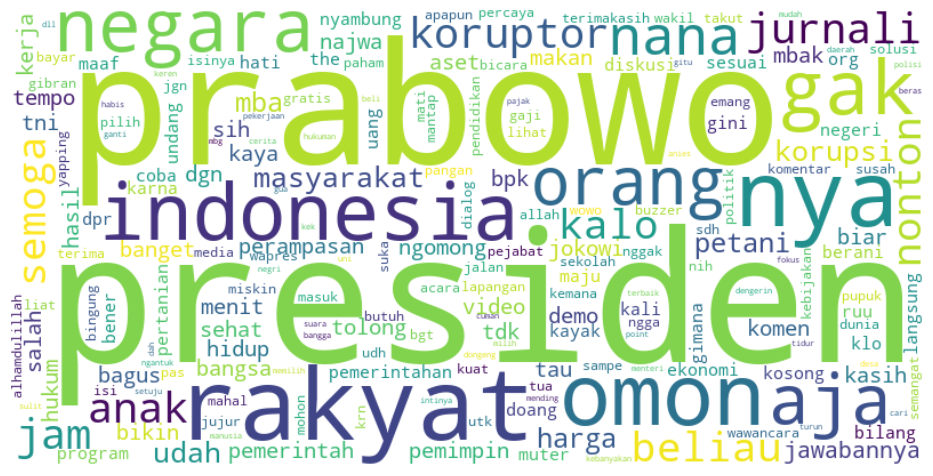

In [36]:
wc = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words, collocations=False).generate(" ".join(df['cleaned_text']))
fig5 = plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
fig5.tight_layout()
fig5.savefig(os.path.join(EDA_VISUAL_DIR, 'wordcloud.png'))
plt.show()

#### 📈 Korelasi Antar Fitur
Menampilkan matriks korelasi antara panjang teks, jumlah kata, dan jumlah like.

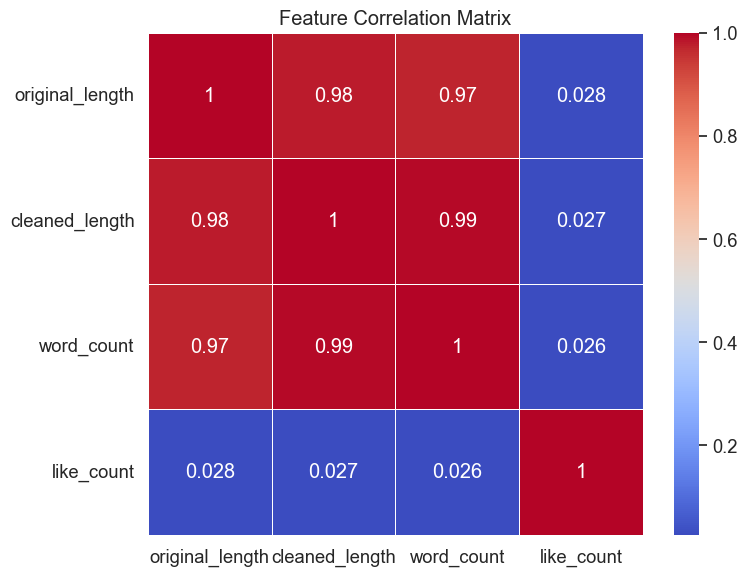

In [37]:
numeric = df[['original_length', 'cleaned_length', 'word_count', 'like_count']]
corr = numeric.corr()
fig6 = plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5).set(title='Feature Correlation Matrix')
fig6.tight_layout()
fig6.savefig(os.path.join(EDA_VISUAL_DIR, 'correlation_matrix.png'))
plt.show()

#### 📊 Ringkasan EDA
Menampilkan metrik-metrik penting hasil analisis eksplorasi data komentar.


In [38]:
summary = {
    'Total Comments':      len(df),
    'Average Word Count':  df['word_count'].mean(),
    'Median Word Count':   df['word_count'].median(),
    'Max Word Count':      df['word_count'].max(),
    'Average Likes':       df['like_count'].mean(),
    'Total Likes':         df['like_count'].sum(),
    'Outlier Count':       len(outliers),
    'Peak Date':           date_counts.idxmax(),
    'Peak Hour':           hour_counts.idxmax()
}

for k, v in summary.items():
    print(f"{k}: {v}")

Total Comments: 10150
Average Word Count: 10.015960591133005
Median Word Count: 6.0
Max Word Count: 339
Average Likes: 11.69487684729064
Total Likes: 118703
Outlier Count: 737
Peak Date: 2025-04-08 00:00:00+00:00
Peak Hour: 16


### Text Clustering Analysis

#### 📦 Membuat folder output untuk menyimpan hasil analisis dan visualisasi cluster, lalu memuat file CSV hasil preprocessing komentar.


In [60]:
ANALYSIS_DIR = subdirs['04_clustering']['analisis']
VISUAL_DIR   = subdirs['04_clustering']['visualisasi']
os.makedirs(ANALYSIS_DIR, exist_ok=True)
os.makedirs(VISUAL_DIR, exist_ok=True)

PREPROCESS_DIR = 'output/02_preprocessing/analisis' 
preprocessed_csv = os.path.join(PREPROCESS_DIR, 'preprocessed_comments.csv')
df = pd.read_csv(preprocessed_csv)

#### 🧠 Mengubah teks yang sudah dibersihkan menjadi representasi numerik menggunakan TF-IDF dengan filtering kata berdasarkan frekuensi kemunculan.

In [61]:
stop_words = list(stopwords.words('indonesian'))

vectorizer    = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7, stop_words=stop_words)
tfidf_matrix  = vectorizer.fit_transform(df['cleaned_text'])
logger.info("TF-IDF matrix shape: %s", tfidf_matrix.shape)

2025-05-09 05:15:48 INFO TF-IDF matrix shape: (10150, 2914)


#### 📈 Menggunakan Elbow Method untuk menentukan jumlah cluster yang optimal dengan memplot nilai inertia terhadap jumlah cluster `k`.

In [62]:
ssd = []
k_values = range(2, 12)
for k in tqdm(k_values, desc="Evaluating k"):
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(tfidf_matrix)
    ssd.append(km.inertia_)

Evaluating k: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.14it/s]


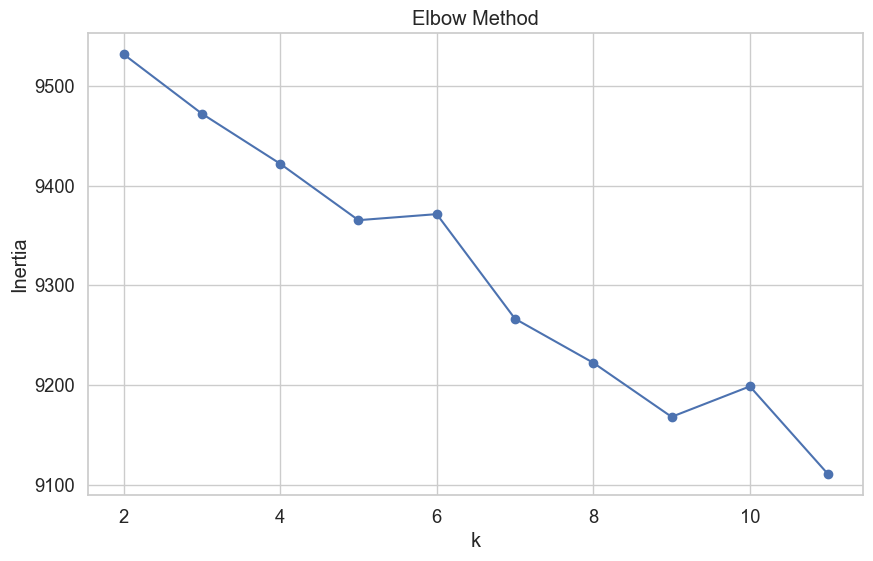

2025-05-09 05:16:56 INFO Saved elbow plot to ./output/04_clustering/visualisasi/elbow_method.png


In [63]:
plt.figure(figsize=(10, 6))
plt.plot(list(k_values), ssd, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)

elbow_path = os.path.join(VISUAL_DIR, 'elbow_method.png')
plt.savefig(elbow_path)
plt.show()
logger.info("Saved elbow plot to %s", elbow_path)

#### 🔐 Melakukan clustering menggunakan KMeans berdasarkan TF-IDF dan menampilkan 10 kata kunci paling representatif dari setiap cluster.

In [64]:
optimal_k = 3
logger.info("Optimal k selected: %d", optimal_k)

kmeans   = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit(tfidf_matrix)
df['cluster'] = kmeans.labels_

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms           = vectorizer.get_feature_names_out()
top_terms       = {
    i: [terms[idx] for idx in order_centroids[i, :10]]
    for i in range(optimal_k)
}
for i, terms_list in top_terms.items():
    logger.info("Cluster %d top terms: %s", i, ", ".join(terms_list))

2025-05-09 05:17:32 INFO Optimal k selected: 3
2025-05-09 05:17:32 INFO Cluster 0 top terms: presiden, nya, gak, rakyat, tempo, aja, indonesia, nana, jam, negara
2025-05-09 05:17:32 INFO Cluster 1 top terms: prabowo, presiden, rakyat, indonesia, sehat, semoga, jokowi, nya, subianto, gak
2025-05-09 05:17:32 INFO Cluster 2 top terms: omon, real, doang, the, presiden, king, gak, jam, isinya, prabowo


#### 📊 Menampilkan jumlah komentar dalam setiap cluster sebagai bar chart untuk melihat distribusi komentar yang terbentuk.


In [65]:
cluster_counts = df['cluster'].value_counts().sort_index()
print("Jumlah data per cluster:")
print(cluster_counts)

Jumlah data per cluster:
cluster
0    8777
1     977
2     396
Name: count, dtype: int64


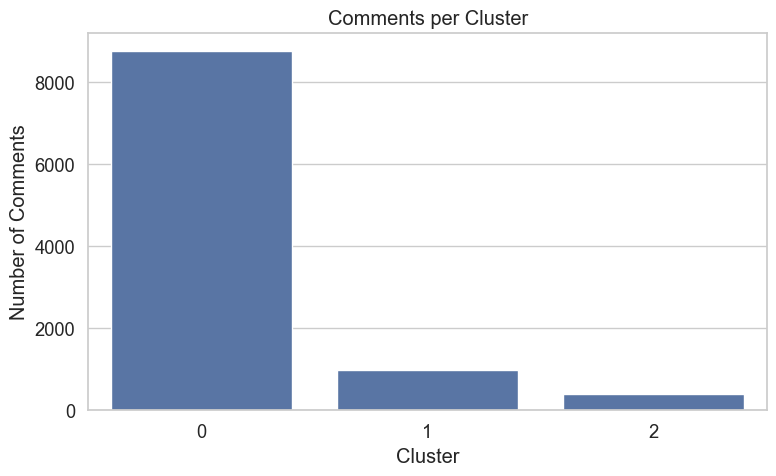

2025-05-09 05:20:12 INFO Saved cluster distribution to ./output/04_clustering/visualisasi/cluster_distribution.png


In [68]:
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Comments')
plt.title('Comments per Cluster')
plt.tight_layout()

dist_path = os.path.join(VISUAL_DIR, 'cluster_distribution.png')
plt.savefig(dist_path)
plt.show()
logger.info("Saved cluster distribution to %s", dist_path)

#### 🗣️ Menampilkan semua komentar yang termasuk dalam masing-masing cluster agar bisa dilihat perbedaan topik atau gaya bahasanya.

In [69]:
display_df = []
for cid in range(optimal_k):
    subset = df[df['cluster'] == cid]
    display_df.append(subset[['author', 'text', 'like_count']])
    display(subset[['author', 'text', 'like_count']].assign(cluster=cid))

,author,text,like_count,cluster
0,@MakmunMaulana-j8v,Kuci likan ka loka lu ciri lu Bangi Gung jawab tu,0,0
1,@MakmunMaulana-j8v,Bangi kang tin satu akan bingan seakan jasnni Nina tu kan kan Bangi nah rus tuk sa Ra inonesa ki...,0,0
2,@Kalandra-qk3bl,kok film jumbo gw begini,0,0
3,@NjiAhmad-x8m,Ngelihat komen masih banyak yg sadar ternyata,0,0
4,@nikozio4981,"Krain maung, Ternyata meow..\nJawaban ga ada yg di jwb",0,0
...,...,...,...,...
10145,@serbaserbiacakadul3773,Assalamualaikum komen pertama,2,0
10146,@japbenny4804,Pertamax,2,0
10147,@abdibsyahputrasebayang3475,Akhirnya ada fullnya,3,0
10148,@muhamadnurpauji8108,Minal aidzin walfaidzin mba najwa🙏,9,0


,author,text,like_count,cluster
5,@Beeyourrselff,"Pak prabowo jangan ketularan wakilnya dong, 3 jam ngulang2 bener2 ujian buat saya.",0,1
10,@jandabaru-l4y,Rakyat Bener 2 nggak Salah Pilih Punya Presiden Seperti PK Prabowo Tegas Berwibawa Dan Benar 2 B...,0,1
19,@SugiantoYanto-b8z,Mantap pk prabowo pidatonya maju terus pk presiden,0,1
22,@Tanggalangit12356,"Pak, mohon pabrik lokal jg di proteksi dr gempuran barang luar terutama barang illegal + serius ...",0,1
32,@IdsaIdsa-q8u,"Semoga terealisasi apa2 yg di cita2kan bapak prabowo dan rakyat indonesia,,",0,1
...,...,...,...,...
10115,@attarasmawan5538,Pak Prabowo coba bisa menunjukkan kesederhanaan bukan dengan kemewahan,0,1
10123,@racunbaca,"bisa diliat kalo prabowo ga paham dengan apa yang terjadi di masyarakat bawah. masalahnya apa, k...",39,1
10127,@AMartono2023,Presiden prabowo. Mantap,1,1
10131,@KeisyaRamadhani1778,"Saya masih sangat respect dengan Najwa Shihab, untuk kali ini saya merasakan pertanyaan sederhan...",570,1


,author,text,like_count,cluster
11,@taufikrahman6917,Omon omon,0,2
69,@sudiono5618,Omon omon ga nyambung,1,2
81,@Victormzmeia,3 jam 26 menit isinya OMON-OMON doang anyinggg,1,2
173,@NunungNurdin-v5g,Pupuk mah Al insek mahalpungisidamahalmakinsuusah ngomonggampang nyatanya OMON OMON dodol,0,2
186,@royprayogi,gak kuat sampe selesai isinya omon omon.............ngantuk bikin mual 😜,0,2
...,...,...,...,...
9958,@UncleSwa,Presiden omon omon sedang ngibul….\nBicara swasembada pangan padahal nanam singkong aja gagal,0,2
10022,@chichaphile4943,omon omon is real 😢,46,2
10060,@IrmansyahAriadin,Omon omon sajaaaa lebih parah dari presiden sebelum nyaaaa... Saya menyesal memilih presiden Pra...,14,2
10066,@JoniIskandar-ii8hf,Halah omon omon,1,2


#### 💾 Menyimpan hasil pengelompokan komentar beserta klasternya ke file CSV untuk analisis lanjutan.

In [70]:
clustered_csv = os.path.join(ANALYSIS_DIR, 'clustered_comments.csv')
df[['author', 'text', 'like_count', 'cluster']].to_csv(clustered_csv, index=False)
logger.info("Saved clustered comments to %s", clustered_csv)

2025-05-09 05:21:21 INFO Saved clustered comments to ./output/04_clustering/analisis/clustered_comments.csv


#### 📉 Menggunakan TruncatedSVD untuk mereduksi dimensi TF-IDF menjadi 2D agar bisa divisualisasikan dalam scatter plot.

In [71]:
svd = TruncatedSVD(n_components=2, random_state=42)
coords = svd.fit_transform(tfidf_matrix)

vis_df = pd.DataFrame(coords, columns=['x', 'y'])
vis_df['x'] = pd.to_numeric(vis_df['x'], errors='coerce')
vis_df['y'] = pd.to_numeric(vis_df['y'], errors='coerce')
vis_df['cluster'] = df['cluster'].astype(str)
vis_df['likes'] = pd.to_numeric(df['like_count'], errors='coerce')

#### 🗺️ Menampilkan plot 2D dari hasil clustering, dengan ukuran titik berdasarkan jumlah likes dan warna berdasarkan cluster.

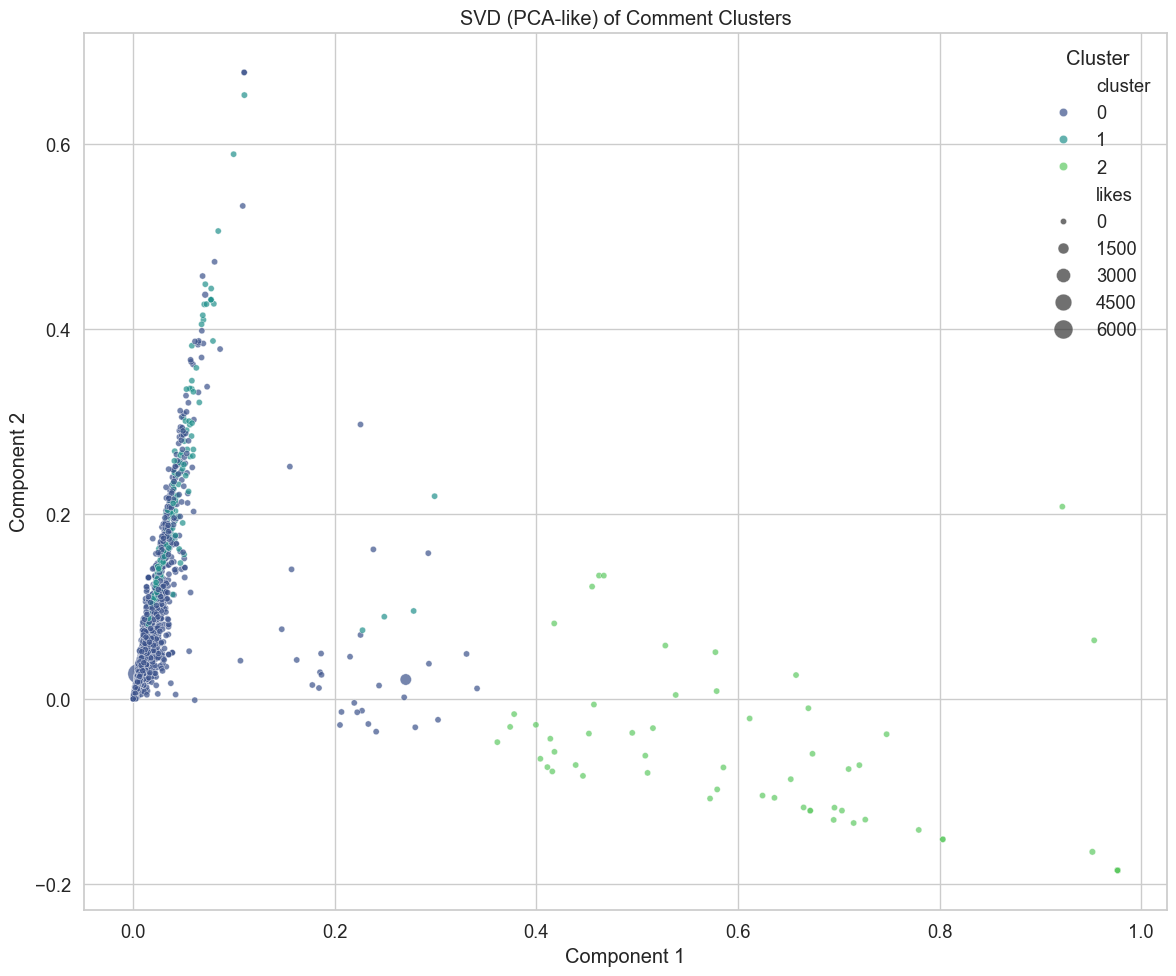

2025-05-09 05:22:46 INFO Saved PCA cluster plot to ./output/04_clustering/visualisasi/cluster_pca.png


In [72]:
sample_frac = 0.2 if len(vis_df) > 5000 else 1.0
vis_sample = vis_df.sample(frac=sample_frac, random_state=42)

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=vis_sample,
    x='x', y='y',
    hue='cluster',
    size='likes',
    sizes=(20, 200),
    alpha=0.7,
    palette='viridis'
)
plt.title('SVD (PCA-like) of Comment Clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Cluster')
plt.tight_layout()

pca_path = os.path.join(VISUAL_DIR, 'cluster_pca.png')
plt.savefig(pca_path)
plt.show()
logger.info("Saved PCA cluster plot to %s", pca_path)


### Sentiment Analysis with Gemini API

#### 💡 Fungsi ini mengirimkan komentar sebagai prompt ke model bahasa, lalu mengekstrak sentimen, alasan, dan rekomendasi dari hasil respons teks.

In [73]:
import re

def analyze_sentiment_with_prompt(comment, model):
    prompt = f"""
    Berikut ini adalah komentar terhadap video YouTube berjudul "Prabowo Menjawab" yang membahas isu-isu pemerintahan.

    Tugas Anda adalah:
    1. Analisis sentimen komentar berikut dalam bahasa Indonesia.
    2. Klasifikasikan sentimen sebagai 'Positif', 'Negatif', atau 'Netral'.
    3. Jelaskan alasan di balik klasifikasi sentimen tersebut.
    4. Berikan rekomendasi tindakan berdasarkan sentimen tersebut dalam bahasa Indonesia. Misalnya:
       - Jika sentimen Positif, berikan saran untuk mendorong lebih banyak interaksi positif dengan audiens.
       - Jika sentimen Negatif, beri saran untuk merespons kritik atau keluhan secara lebih konstruktif, atau memberikan klarifikasi.
       - Jika sentimen Netral, beri saran untuk memperjelas pernyataan atau mengajak diskusi lebih lanjut.

    Komentar:
    "{comment}"

    **Gunakan format jawaban ini saja, tanpa tambahan apapun:**
    Sentimen: [Positif/Negatif/Netral]
    Alasan: [Alasan mengapa komentar ini diklasifikasikan sebagai Positif/Negatif/Netral]
    Rekomendasi: [rekomendasi tindakan dalam bahasa Indonesia]
    """
    
    try:
        response = model.generate_content(prompt)
        text = response.text
        
        sentiment_match = re.search(r'Sentimen: (.*)', text)
        reason_match = re.search(r'Alasan: (.*)', text)
        recommendation_match = re.search(r'Rekomendasi: (.*)', text)
        
        sentiment = sentiment_match.group(1).strip() if sentiment_match else "Tidak Diketahui"
        reason = reason_match.group(1).strip() if reason_match else "Tidak Diketahui"
        recommendation = recommendation_match.group(1).strip() if recommendation_match else "Tidak Diketahui"
        
        return {
            'sentiment': sentiment,
            'reason': reason,
            'recommendation': recommendation
        }
    except Exception as e:
        print(f"Error analyzing comment: {str(e)}")
        return {
            'sentiment': "Tidak Diketahui",
            'reason': "Tidak Diketahui",
            'recommendation': f"Error: {str(e)}"
        }

#### 🧪 Mengambil sampel acak sebanyak 8000 komentar dari semua cluster untuk dianalisis.

In [74]:
comments_combined = df.sample(n=8000, random_state=42)
print(f"🔍 Sampled total {len(comments_combined)} comments from all clusters.")

🔍 Sampled total 8000 comments from all clusters.


#### 🔁 Loop ini menjalankan analisis sentimen per komentar, menangani rate-limit (error 429), dan mengganti model jika perlu.

In [ ]:
results = []
model_index = 0

for cluster_id in sorted(comments_combined['cluster'].unique()):
    cluster_comments = comments_combined[comments_combined['cluster'] == cluster_id].reset_index(drop=True)
    
    print(f"🔄 Analyzing sentiment for cluster {cluster_id} with {len(cluster_comments)} comments...")
    
    for i, row in cluster_comments.iterrows():
        retry_count = 0
        while retry_count < 5:
            try:
                model_to_use = models[model_index]
                result = analyze_sentiment_with_prompt(row['text'], model_to_use)
                
                results.append({
                    'cluster_id': cluster_id,
                    'comment_id': row.get('comment_id', i),
                    'text': row['text'],
                    'author': row['author'],
                    'like_count': row['like_count'],
                    'sentiment': result['sentiment'],
                    'reason': result['reason'],
                    'recommendation': result['recommendation']
                })
                break
            except Exception as e:
                if '429' in str(e):
                    retry_count += 1
                    print(f"Rate limit exceeded on model {model_index + 1}, switching to next model. Retry attempt {retry_count}/5.")
                    model_index = (model_index + 1) % len(models)
                    time.sleep(60)
                else:
                    print(f"Error analyzing comment: {e}")
                    break

        if (i + 1) % 20 == 0:
            print(f"🔄 {i+1} comments processed, waiting for 40 seconds...")
            time.sleep(40)

#### 🧹💾 Membersihkan data dari hasil yang gagal, lalu menyimpan hasil analisis sentimen ke file .csv.

In [ ]:
df_sentiment = pd.DataFrame(results)

df_sentiment_clean = df_sentiment[
    (df_sentiment['sentiment'] != "Tidak Diketahui") &
    (~df_sentiment['recommendation'].str.startswith("Error"))
].reset_index(drop=True)

output_dir = "output/05_sentiment"
os.makedirs(output_dir, exist_ok=True)
analisis_dir = os.path.join(output_dir, "analisis")
visualisasi_dir = os.path.join(output_dir, "visualisasi")
os.makedirs(analisis_dir, exist_ok=True)
os.makedirs(visualisasi_dir, exist_ok=True)

sentiment_path = os.path.join(analisis_dir, "sentiment_analysis_sample.csv")
df_sentiment_clean.to_csv(sentiment_path, index=False)

print(f"💾 Sentiment analysis results saved to {sentiment_path}")

#### 📈 Menampilkan distribusi jumlah komentar Positif, Negatif, dan Netral di setiap cluster.

In [ ]:
sentiment_by_cluster = df_sentiment_clean.groupby(['cluster_id', 'sentiment']).size().unstack(fill_value=0)
print("\n📊 Sentiment Distribution by Cluster:")
print(sentiment_by_cluster)

#### 🖼️ Membuat grafik batang tumpuk untuk menunjukkan persebaran sentimen di setiap cluster, lalu menyimpannya sebagai gambar PNG.

In [ ]:
import matplotlib.pyplot as plt

sentiment_by_cluster.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set3')
plt.title("Sentiment Distribution per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Comments")
plt.xticks(rotation=0)
plt.tight_layout()

visualization_path = os.path.join(visualisasi_dir, "sentiment_per_cluster.png")
plt.savefig(visualization_path)
plt.show()